# Modeling Time Series Using Parametric Methods


In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from acquire import get_all_data
from prepare import prep_store_data, split_store_data

# Acquire

In [2]:
df = get_all_data()

In [3]:
df.head()

,item_id,sale_amount,sale_date,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode
0,1,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
1,1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
2,1,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
3,1,13.0,"Fri, 04 Jan 2013 00:00:00 GMT",4,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
4,1,10.0,"Sat, 05 Jan 2013 00:00:00 GMT",5,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253


# Prepare

In [4]:
df = prep_store_data(df)

In [5]:
df.head()

,item_id,sale_amount,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode,month,weekday,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,13.0,1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,01-Jan,2-Tue,10.92
2013-01-01 00:00:00+00:00,17,26.0,295813,3,Ducal,Ducal Refried Red Beans,1.16,88313590791,88313590791,2118 Fredericksburg Rdj,San Antonio,TX,78201,01-Jan,2-Tue,30.16
2013-01-01 00:00:00+00:00,7,32.0,125995,10,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,70177154004,70177154004,8503 NW Military Hwy,San Antonio,TX,78231,01-Jan,2-Tue,308.48
2013-01-01 00:00:00+00:00,18,45.0,314073,3,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,21200725340,21200725340,2118 Fredericksburg Rdj,San Antonio,TX,78201,01-Jan,2-Tue,197.55
2013-01-01 00:00:00+00:00,19,34.0,332333,3,Careone,Careone Family Comb Set - 8 Ct,0.74,41520035646,41520035646,2118 Fredericksburg Rdj,San Antonio,TX,78201,01-Jan,2-Tue,25.16


# Resample

In [6]:
df2 = pd.DataFrame(df['sale_amount'].resample('D').sum())

In [7]:
df2.shape

(1826, 1)

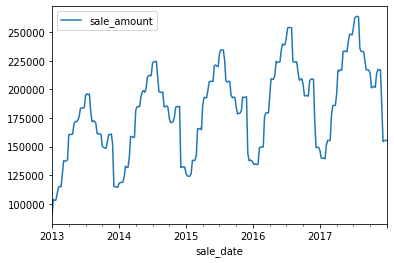

In [8]:
pd.DataFrame(df2['sale_amount'].resample('W').sum()).plot()

plt.show()

In [9]:
df2 = pd.DataFrame(df2['sale_amount'].resample('W').sum())

# Split

In [10]:
train, test = split_store_data(df2)

In [11]:
train.shape

(172, 2)

In [12]:
test.shape

(89, 2)

In [13]:
print('Observations: %d' % (len(df2)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 261
Training Observations: 172
Testing Observations: 89


In [14]:
train = train.set_index('sale_date')
test = test.set_index('sale_date')

In [15]:
train.head()

,sale_amount
sale_date,
2013-01-06 00:00:00+00:00,91067.0
2013-01-13 00:00:00+00:00,103902.0
2013-01-20 00:00:00+00:00,102950.0
2013-01-27 00:00:00+00:00,103298.0
2013-02-03 00:00:00+00:00,109027.0


# Plot

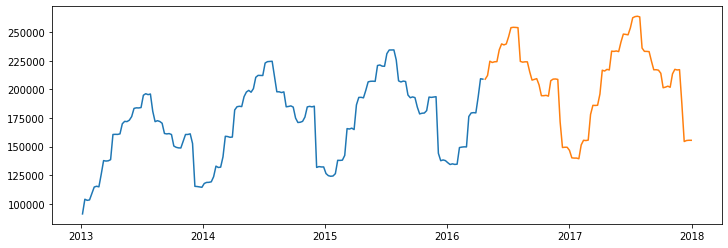

In [16]:
plt.figure(figsize=(12, 4))

plt.plot(train)
plt.plot(test)
plt.show()

# Forecast

In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2013-01-06 00:00:00+00:00 to 2017-12-31 00:00:00+00:00
Freq: W-SUN
Data columns (total 1 columns):
sale_amount    261 non-null float64
dtypes: float64(1)
memory usage: 4.1 KB


### Forecast Simple Average

In [50]:
target_vars = ['sale_amount']

for var in target_vars:
    yhat[var] = train[var].mean()

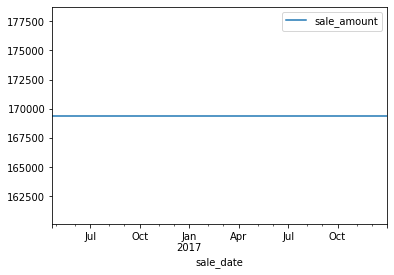

In [52]:
yhat.plot()

### Forecast Last Observed

In [47]:
#target_vars = ['sale_amount']

yhat = pd.DataFrame(test[target_vars])

In [48]:
for var in target_vars:
    yhat[var] = int(train[var][-1:])

In [49]:
yhat.head()

,sale_amount
sale_date,
2016-04-24 00:00:00+00:00,208943
2016-05-01 00:00:00+00:00,208943
2016-05-08 00:00:00+00:00,208943
2016-05-15 00:00:00+00:00,208943
2016-05-22 00:00:00+00:00,208943
